### Store Item Demand Forecasting Challenge

Predict 3 months of item sales at different stores (deep learning)

In [32]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from tensorflow.keras.utils import get_custom_objects
from keras import optimizers
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



# Set seeds to make the experiment more reproducible.
import tensorflow
tensorflow.random.set_seed(1)


In [3]:
train = pd.read_csv("./train.csv", parse_dates=['date'])
test = pd.read_csv("./test.csv", parse_dates=['date'])

# Convert the date column to a datetime format
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])


# Extract year, month, and day as separate columns
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day


In [4]:
print("Train data table")
print(train.head())
print("\n")
print("Test data table")
print(test.head())

Train data table
        date  store  item  sales  year  month  day
0 2013-01-01      1     1     13  2013      1    1
1 2013-01-02      1     1     11  2013      1    2
2 2013-01-03      1     1     14  2013      1    3
3 2013-01-04      1     1     13  2013      1    4
4 2013-01-05      1     1     10  2013      1    5


Test data table
   id       date  store  item  year  month  day
0   0 2018-01-01      1     1  2018      1    1
1   1 2018-01-02      1     1  2018      1    2
2   2 2018-01-03      1     1  2018      1    3
3   3 2018-01-04      1     1  2018      1    4
4   4 2018-01-05      1     1  2018      1    5


In [5]:
traindb = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
traindb = traindb.agg({'sales':['mean']})
traindb.columns = ['item', 'store', 'date', 'sales']
traindb.head()

,item,store,date,sales
0,1,1,2013-01-01,13.0
1,1,1,2013-01-02,11.0
2,1,1,2013-01-03,14.0
3,1,1,2013-01-04,13.0
4,1,1,2013-01-05,10.0


Text(0.5, 1.0, 'Sales by Date')

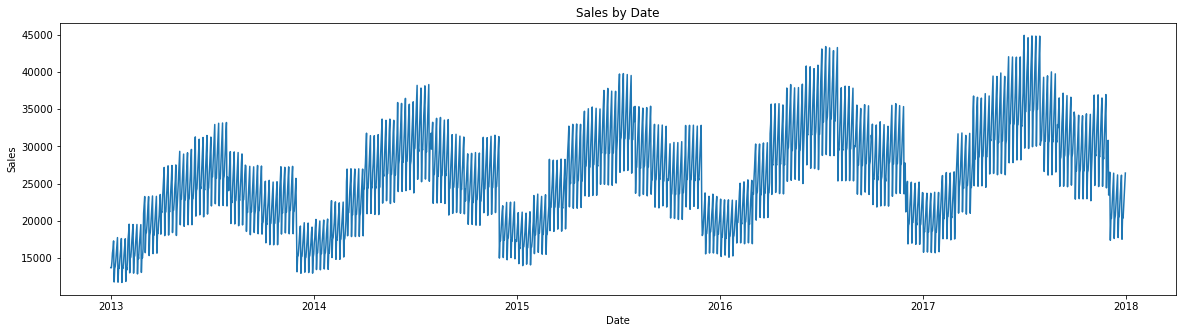

In [6]:
# Group the sales data by date and calculate the sum of sales for each day
sales_by_date = train.groupby('date')['sales'].sum()


# Specify the chart size
plt.figure(figsize=(20, 5))
# Plot the sales data as a time-based chart
plt.plot(sales_by_date.index, sales_by_date.values)
# Set the x-axis label
plt.xlabel('Date')
# Set the y-axis label
plt.ylabel('Sales')
# Set the chart title
plt.title('Sales by Date')

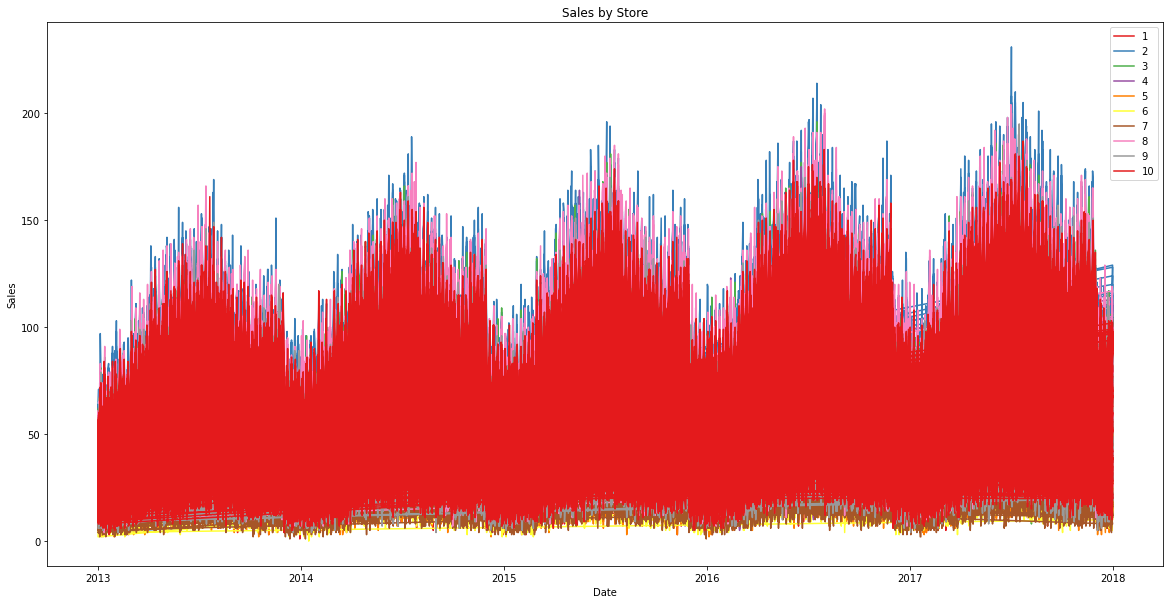

In [7]:
# Group the sales data by store
sales_by_store = train.groupby('store')

# Specify the chart size
plt.figure(figsize=(20, 10))

# Define a color palette and assign a color to each store
palette = sns.color_palette('Set1', len(sales_by_store))
store_colors = {store: color for store, color in zip(sales_by_store.groups.keys(), palette)}

# Plot the sales data for each store using the assigned color
for store, group in sales_by_store:
    plt.plot(group['date'], group['sales'], label=store, color=store_colors[store])

# Set the chart title, x-axis label, y-axis label, and legend
plt.title('Sales by Store')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# Show the chart
plt.show()

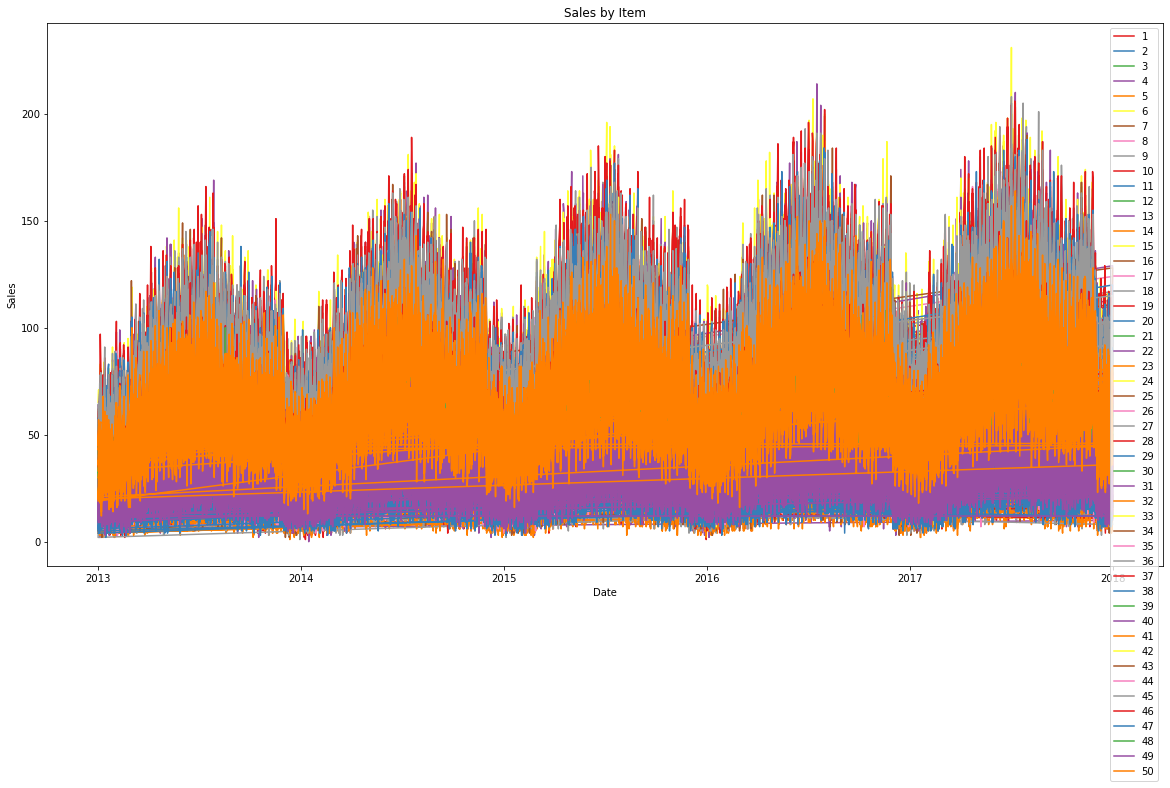

In [8]:
# Group the sales data by store
sales_by_store = train.groupby('item')

# Specify the chart size
plt.figure(figsize=(20, 10))

# Define a color palette and assign a color to each store
palette = sns.color_palette('Set1', len(sales_by_store))
store_colors = {store: color for store, color in zip(sales_by_store.groups.keys(), palette)}

# Plot the sales data for each store using the assigned color
for store, group in sales_by_store:
    plt.plot(group['date'], group['sales'], label=store, color=store_colors[store])

# Set the chart title, x-axis label, y-axis label, and legend
plt.title('Sales by Item')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# Show the chart
plt.show()

## Functions for DeepLearning

In [9]:
# Transform the data into a time series problem


def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-12-31
Max date from test set: 2018-03-31
Forecast lag size 90


In [13]:
window = 29
lag = lag_size
series = series_to_supervised(traindb.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,13.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,...,11.0,1.0,1.0,6.0,1,1,9.0,1.0,1.0,15.0
30,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,...,6.0,1.0,1.0,9.0,1,1,13.0,1.0,1.0,16.0
31,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,...,9.0,1.0,1.0,13.0,1,1,11.0,1.0,1.0,23.0
32,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,...,13.0,1.0,1.0,11.0,1,1,21.0,1.0,1.0,22.0
33,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,10.0,1.0,...,11.0,1.0,1.0,21.0,1,1,15.0,1.0,1.0,20.0


In [14]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [15]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [16]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (539046, 30)
Validation set shape (359364, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
418620,35.0,32.0,36.0,20.0,22.0,27.0,26.0,38.0,34.0,34.0,...,35.0,26.0,45.0,38.0,29.0,26.0,30.0,27.0,25.0,41.0
224141,105.0,104.0,121.0,87.0,89.0,121.0,106.0,115.0,126.0,147.0,...,106.0,117.0,93.0,131.0,78.0,105.0,101.0,114.0,127.0,115.0
38187,39.0,40.0,35.0,45.0,41.0,58.0,36.0,47.0,41.0,43.0,...,46.0,43.0,40.0,41.0,59.0,43.0,68.0,46.0,39.0,37.0
885034,26.0,35.0,34.0,19.0,14.0,26.0,21.0,32.0,24.0,35.0,...,23.0,42.0,35.0,35.0,19.0,18.0,26.0,31.0,32.0,34.0
199559,63.0,85.0,85.0,91.0,98.0,100.0,99.0,67.0,86.0,77.0,...,110.0,73.0,85.0,102.0,94.0,85.0,106.0,128.0,67.0,92.0


In [17]:
epochs = 10
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [18]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (539046, 30, 1)
Validation set shape (359364, 30, 1)


##### Built-in RNNs support a number of useful features:

Recurrent dropout, via the dropout and recurrent_dropout arguments
Ability to process an input sequence in reverse, via the go_backwards argument
Loop unrolling (which can lead to a large speedup when processing short sequences on CPU), via the unroll argument
...and more.
For more information, see the RNN API documentation.

In [19]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In the context of deep learning, an epoch refers to one complete iteration over the entire dataset during training. During each epoch, the model makes predictions on the training data, calculates the loss between the predicted values and the actual values, and updates the model's parameters to minimize the loss.

One epoch consists of multiple iterations, where each iteration processes a batch of data. The number of iterations per epoch depends on the batch size, which is the number of samples that the model processes at once before updating the parameters.

For example, if you have a dataset of 1000 samples and a batch size of 32, it will take 32 iterations to process the entire dataset once, so one epoch will consist of 32 iterations.

In general, increasing the number of epochs can improve the model's performance up to a point, as the model has more opportunities to learn from the data. However, training the model for too many epochs can lead to overfitting, where the model starts to memorize the training data instead of learning to generalize to new data. It's important to monitor the model's performance on a separate validation set and use techniques such as early stopping to prevent overfitting.

In [20]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/10
16846/16846 - 157s - loss: 679.4914 - val_loss: 355.6015 - 157s/epoch - 9ms/step
Epoch 2/10
16846/16846 - 164s - loss: 311.9509 - val_loss: 296.0508 - 164s/epoch - 10ms/step
Epoch 3/10
16846/16846 - 143s - loss: 287.7502 - val_loss: 280.2260 - 143s/epoch - 9ms/step
Epoch 4/10
16846/16846 - 152s - loss: 282.6251 - val_loss: 273.5908 - 152s/epoch - 9ms/step
Epoch 5/10
16846/16846 - 148s - loss: 313.3962 - val_loss: 296.0432 - 148s/epoch - 9ms/step
Epoch 6/10
16846/16846 - 148s - loss: 292.4142 - val_loss: 290.4297 - 148s/epoch - 9ms/step
Epoch 7/10
16846/16846 - 163s - loss: 281.1104 - val_loss: 289.8286 - 163s/epoch - 10ms/step
Epoch 8/10
16846/16846 - 151s - loss: 277.6718 - val_loss: 271.7327 - 151s/epoch - 9ms/step
Epoch 9/10
16846/16846 - 157s - loss: 1522.1925 - val_loss: 3270.9448 - 157s/epoch - 9ms/step
Epoch 10/10
16846/16846 - 175s - loss: 1102.6426 - val_loss: 521.8211 - 175s/epoch - 10ms/step


In [30]:
lstm_train_pred = model_lstm.predict(X_train_series)
#print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))

16846/16846 [==============================] - 71s 4ms/step


In [33]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

11231/11231 [==============================] - 53s 5ms/step
Train rmse: 22.84951185947319
Validation rmse: 22.843417908160784


In [56]:
# Save the test dataset with predicted sales values to a CSV file

s = lstm_train_pred[:len(test['sales'])]
test['sales'] = np.round(s)
#test[['id', 'sales']].to_csv('predictions.csv', index=False)
#test.to_csv('predicted_sales.csv', index=False)

Text(0.5, 1.0, 'Sales by Date')

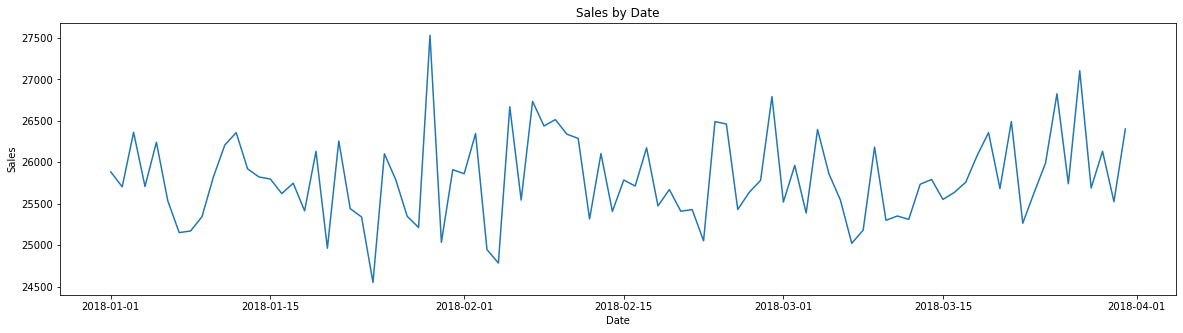

In [57]:
# Group the sales data by date and calculate the sum of sales for each day
sales_by_date = test.groupby('date')['sales'].sum()


# Specify the chart size
plt.figure(figsize=(20, 5))
# Plot the sales data as a time-based chart
plt.plot(sales_by_date.index, sales_by_date.values)
# Set the x-axis label
plt.xlabel('Date')
# Set the y-axis label
plt.ylabel('Sales')
# Set the chart title
plt.title('Sales by Date')

In [58]:
test

,id,date,store,item,year,month,day,sales
0,0,2018-01-01,1,1,2018,1,1,42.0
1,1,2018-01-02,1,1,2018,1,2,101.0
2,2,2018-01-03,1,1,2018,1,3,42.0
3,3,2018-01-04,1,1,2018,1,4,35.0
4,4,2018-01-05,1,1,2018,1,5,110.0
...,...,...,...,...,...,...,...,...
44995,44995,2018-03-27,10,50,2018,3,27,56.0
44996,44996,2018-03-28,10,50,2018,3,28,74.0
44997,44997,2018-03-29,10,50,2018,3,29,46.0
44998,44998,2018-03-30,10,50,2018,3,30,33.0
